In [ ]:
# MEMORY CLEAN
# import gc
# gc.collect()
from IPython import get_ipython
get_ipython().run_line_magic('reset',  '-sf')

In [68]:
# Restart script
import os
import sys

def restart_program():
    """Restarts the current program, with file objects and descriptors cleanup"""
    try:
        p = psutil.Process(os.getpid())
        for handler in p.get_open_files() + p.connections():
            os.close(handler.fd)
    except Exception as e:
        logging.error(e)
    python = sys.executable
    os.execl(python, python, *sys.argv)

In [52]:
# IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

In [166]:
# DATA WRANGLER
path1 = os.path.join("openbiomechanics", "baseball_pitching", "data", "metadata.csv")
meta_data = pd.read_csv(path1)
path2 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "forces_moments.csv")
data = pd.read_csv(path2)
path3 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "force_plate.csv")
force_data = pd.read_csv(path3)
path4 = os.path.join("openbiomechanics", "baseball_pitching", "data", "poi", "poi_metrics.csv")
poi = pd.read_csv(path4)

## MAC IMPORT
# In DrivelinePython
# meta_data = pd.read_csv('originalmetadata.csv')
# data = pd.read_csv('forces_moments.csv')
# poi = pd.read_csv('poi_metrics.csv')

# data.groupby('session_pitch').count()
# force_data.groupby('session_pitch').count()
# meta_data.groupby('session_pitch').count()

# Filter by pitch speed, sort by ID num
meta_data = meta_data[meta_data.pitch_speed_mph >= 70].sort_values(by=['session_pitch'], ascending=True)
meta_data['session_pitch'] = meta_data['session_pitch'].str.replace('_', '.', regex=False)
poi['session_pitch'] = poi['session_pitch'].str.replace('_', '.', regex=False)
# Filter session ID by first trial (..._1)
filt_meta_data = meta_data[meta_data['session_pitch'].str.endswith('1')]
constr_data = pd.merge(filt_meta_data[['session_pitch']], data, on='session_pitch', how='left')
constr_poi = pd.merge(filt_meta_data[['session_pitch']], poi, on='session_pitch', how='left')
constr_poi.drop(columns=['session', 'p_throws', 'pitch_type', 'session_pitch', 'pitch_speed_mph'], inplace=True)
reg_poi = constr_poi.copy()
elbow_varus_moment = reg_poi.elbow_varus_moment
vars = reg_poi.columns.tolist()		# Output to list to constrain below...
reg_poi.drop(columns=['elbow_varus_moment','peak_rfd_lead','peak_rfd_rear','lead_grf_angle_at_max','lead_grf_mag_max','lead_grf_z_max',
					  'lead_grf_y_max','lead_grf_x_max','rear_grf_angle_at_max','rear_grf_mag_max','rear_grf_z_max','rear_grf_y_max',
					  'rear_grf_x_max','thorax_distal_transfer_fp_br','pelvis_lumbar_transfer_fp_br','rear_knee_absorption_pkh_fp',
					  'rear_knee_generation_pkh_fp','rear_knee_transfer_pkh_fp','rear_hip_absorption_pkh_fp','rear_hip_generation_pkh_fp',
					  'rear_hip_transfer_pkh_fp','lead_knee_absorption_fp_br','lead_knee_generation_fp_br','lead_knee_transfer_fp_br',
					  'lead_hip_absorption_fp_br','lead_hip_generation_fp_br','lead_hip_transfer_fp_br','elbow_absorption_fp_br',
					  'elbow_generation_fp_br','elbow_transfer_fp_br','shoulder_absorption_fp_br','shoulder_generation_fp_br',
					  'shoulder_transfer_fp_br','shoulder_internal_rotation_moment'], inplace=True)


In [167]:
# STATISTICS
mean_age = np.mean(filt_meta_data.age_yrs)
std_age = np.std(filt_meta_data.age_yrs)
mean_height = np.mean(filt_meta_data.session_height_m)
std_height = np.std(filt_meta_data.session_height_m)
mean_mass = np.mean(filt_meta_data.session_mass_kg)
std_mass = np.std(filt_meta_data.session_mass_kg)
# filt_meta_data['playing_level_num'] = filt_meta_data['playing_level'].replace({'college': 1, 'independent': 2, 'milb': 3})
val_counts = filt_meta_data['playing_level'].value_counts()
rel_dist = filt_meta_data['playing_level'].value_counts(normalize=True)
playing_levels = pd.DataFrame({'Playing Level': val_counts.index, 'Amount': val_counts.values, 'Relative Distribution (%)': rel_dist.values * 100})

descriptives_table = {
	'Descriptive': ['Age (years)', 'Height (m)', 'Mass (kg)'],
	'Mean': [mean_age, mean_height, mean_mass],
	'Std Dev': [std_age, std_height, std_mass]
}

# Decide Split for "injury risk" qualification (quartiles may constrain sample too much)
# median = np.median(constr_poi.elbow_varus_moment)
# varus = pd.DataFrame({
#	'varus': (constr_poi.elbow_varus_moment > median).astype(int)
# })
# low_varus = constr_poi[constr_poi.elbow_varus_moment <= median]
# high_varus = constr_poi[constr_poi.elbow_varus_moment > median]

In [168]:
# CART
# Regression Tree Features
features = reg_poi.columns.tolist()

# Regression Model
reg = DecisionTreeRegressor(
	random_state=42,
	max_depth=5,			# Tree complexity
	min_samples_split=10,	# Require > 5 samples to split
	min_samples_leaf=10,		# Require > 5 samples per leaf
	min_impurity_decrease=0.01
	)

# Cross Validation
cv_scores = cross_val_score(reg, reg_poi[features], elbow_varus_moment,
						 cv=2,
						 scoring='neg_mean_squared_error')
print(f"CV MSE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Fit Tree & Feature Importances
reg.fit(reg_poi[features], elbow_varus_moment)
importances = {f: imp for f, imp in zip(features, reg.feature_importances_) if imp > 0}
print("Non-zero Feature Importances:", importances)

# Check w/ Linear model (scaled)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(reg_poi[features], elbow_varus_moment)
coefs = {f: c for f, c in zip(features, pipe.named_steps['linearregression'].coef_) if abs(c) > 0.01}
print(f"Linear Model r²: {pipe.score(reg_poi[features], elbow_varus_moment):.4f}")
print("Significant Linear Coefficients:", coefs)

null_pred = np.mean(elbow_varus_moment)
null_mse = np.mean((elbow_varus_moment - null_pred)**2)
print(f"Null Model MSE: {null_mse:.2f}")

CV MSE: 391.48 ± 16.62
Non-zero Feature Importances: {'max_rotation_hip_shoulder_separation': 0.07880742814416763, 'max_shoulder_external_rotation': 0.33270292472216195, 'shoulder_abduction_fp': 0.2334980132213209, 'shoulder_external_rotation_fp': 0.14230065955667984, 'torso_lateral_tilt_fp': 0.21269097435566967}
Linear Model r²: 0.5847
Significant Linear Coefficients: {'max_shoulder_internal_rotational_velo': 0.6118178394982366, 'max_elbow_extension_velo': -3.9248645057471006, 'max_torso_rotational_velo': -1.3453043459917868, 'max_rotation_hip_shoulder_separation': 3.2379756941020443, 'max_elbow_flexion': -2.5265774968343835, 'max_shoulder_external_rotation': -11.870740420363784, 'elbow_flexion_fp': 3.892842248948066, 'elbow_pronation_fp': 1.7298299269397754, 'rotation_hip_shoulder_separation_fp': 12.155917953205233, 'shoulder_horizontal_abduction_fp': 6.944671642649359, 'shoulder_abduction_fp': 4.379978467315959, 'shoulder_external_rotation_fp': 4.755358077021945, 'lead_knee_extensio

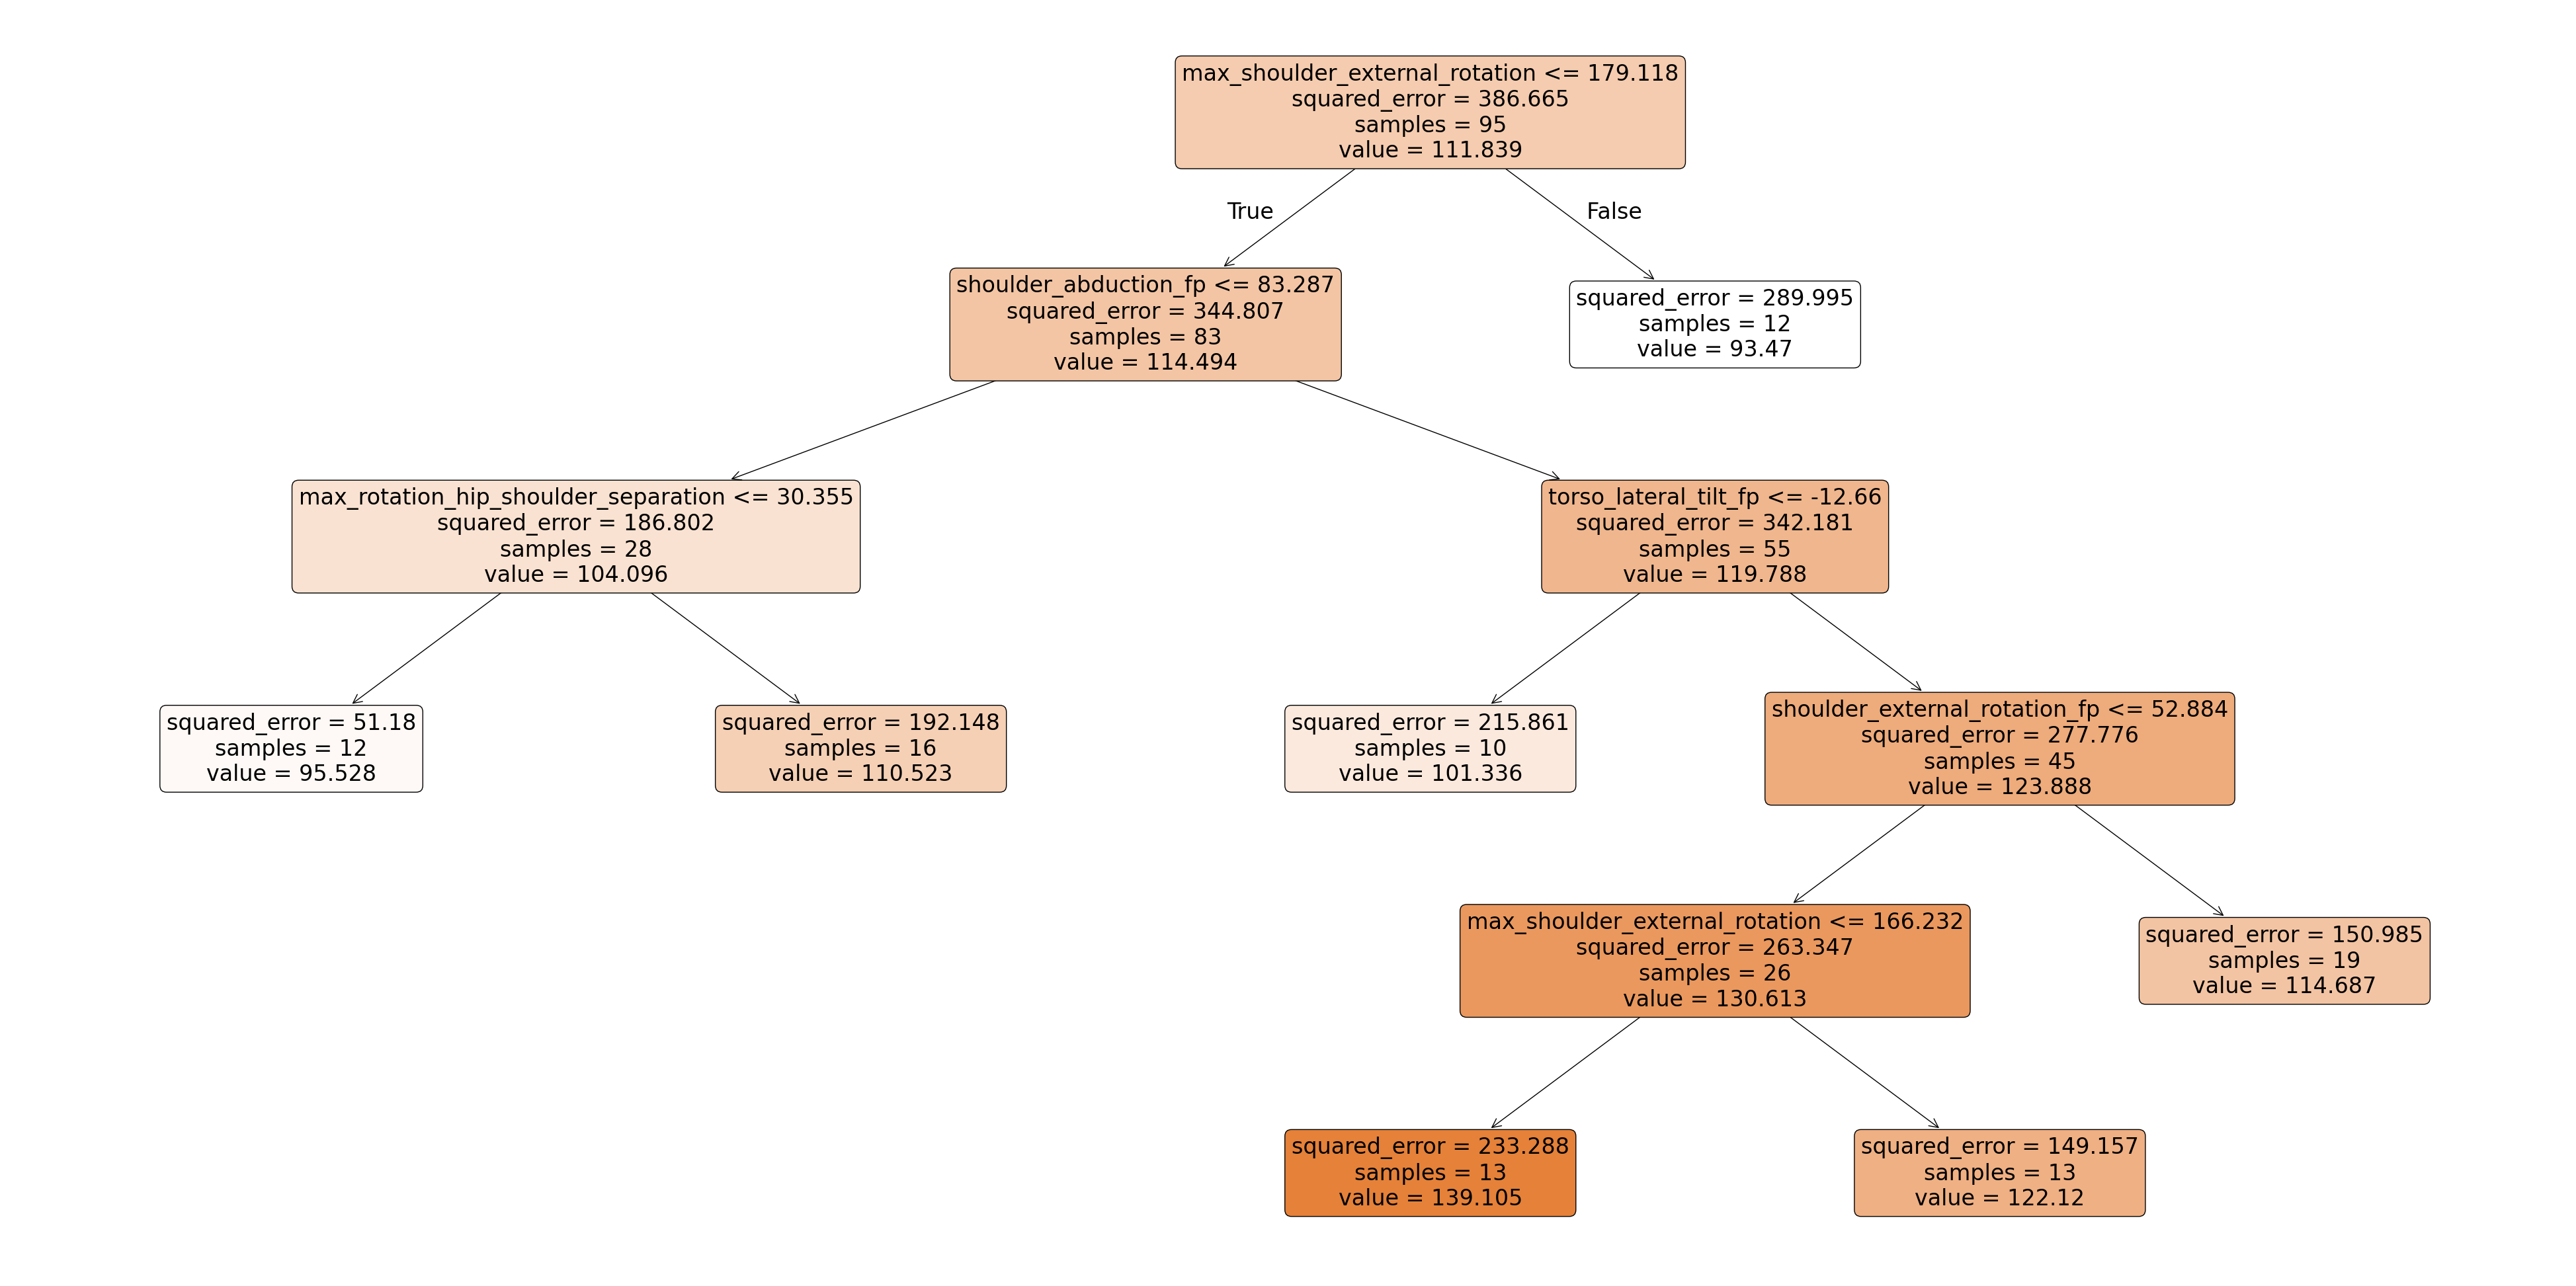

In [169]:
# Visualize
from sklearn.tree import plot_tree

plt.figure(figsize=(50,25))
plot_tree(reg, feature_names=features, filled=True, rounded=True)
plt.show()

# Comments, first output:
# Max shoulder internal rotation velocity is the largest indicator of elbow varus torque (EVT).
# True Branch: Pitchers with lower MIR velo will have lower EVT. 
# False Branch: Pitchers with  higher MIR velo will have higher EVT.
# New model? Train based on proximal/distal influence (i.e. begin with lead knee kinematics)